###### Title:
###### Authors:
###### Date:

In [30]:
# imports 
from matplotlib import pyplot as plt

# 1) Analysis of the Serial Algorithm


## String Matching

The algorithms for the search of substrings called pattern-string (of length $M$), in a larger string called text-string (of length $N$) are of fundamental importance, and have applications in many different fields. 

## The Rabin-Karp Algorithm

It is an algorithm that uses a rolling-hash function that allows it to achieve performances in the order of $O(M + N)$, with high probability. This is a completely different approach to brute-force, substring searching is based on hashing. 

### The operations  can be summarized in these few lines:
* Compute a hash function for the pattern
* Aearch for a match using the same hash function for each possible substring of characters $M$ of the text
* If we find a text substring with the same hash value as the pattern, check the match (Note: a matching hash does NOT imply a matching string)

## Role of the Rolling-Hash Function:

Be aware, however, that a direct implementation based on the above description would be much slower than a brute force search. Computing a hash function involving each character is probably much more expensive than just comparing characters. But Rabin and Karp showed that it is easy to compute hash functions for character substrings M in constant time (after some preprocessing). This leads to a search for substrings in linear time in practical situations, i.e. at the average performance (high probability) we have indicated.

## How does the Hash work?

The underlying theory is the following: we know that a string of length M corresponds to a base-$R$ number of $M$ digits ($R$: alphabet size). If I want to use a hash table of size $Q$ for keys of this type, we need a hash function to convert a base-$R$ $M$-digit number to an int value between $0$ and $Q-1$. Modular hashing can be a good idea:

$hash (x) = x\;mod\;Q$

Basically, we use $Q$, a random prime number, as large as possible.

<img src="./images/image1.png" width="300" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">

As already mentioned, Rabin-Karp does not compute hashing on all strings of length $M$, to find the one with the same hash and then make the comparison. But we use the "mathematical trick" exploited by Rabin and Karp.
This "trick" leads, after preprocessing, to compute hashes in constant time. It exploits Horner's rule which states that it is possible to evaluate a polynomial of degree $N$ by carrying out only $N$ additions and $N$ multiplications. 


Example:

$ a_{2}* x^{2} + a_{1} * x + ... + a_{0} = (a^{2} * x + a_{1}) * x + a_{0} $


This identity holds true for modulo-arithmetics, the one we use for hashing, where the following applies:


$ (a_{2} * x^{2} + a_{1} * x + ... + a_{0})\;mod\;z = (((a_{2} * x + a_{1})\;mod\;z) * x + a_{0})\;mod\;z $


The Rabin-Karp method is based on efficiently computing the hash function $x_{i+1}$ for the position $i+1$ in the text, given its value for position $i$, $x_{i}$. Example:

$ x_{i}= t_{i} * RM^{-1} + t_{i}+1 * RM^{-2} + ... + t_{i} + M^{-1} * R0 $
$ x_{i+1} = t_{i+1} * RM + t_{i} * RM^{-1} + ... + t_{i} + M * R0 $

$ x_{i+1} = (x_{i} - t_{i} * RM^{-1}) * R + t_{i}+M $

We do not have to keep the values ​​of the numbers, only the values ​​of their remainder divided by $Q$. The algorithm is then used iteratively, calculating the hash of the next string, using that of the previous one as in the formula above.

<img src="./images/image2.png" width="300" style="display: block; margin-left: auto; margin-right: auto; width: 50%;">

Once we find a hash value for a substring of text of characters M that matches the hash value of the pattern, we do not test for match or collision. Matching requires M to be matched against the text string and this degrades performance. But if we make $Q$ very large, we make the probability of a collision extremely small. With a $Q$ value greater than $10^{20}$, we make the probability of a collision equal to $10^{-20}$.

This algorithm is a first and famous example of a <em>Monte Carlo</em> algorithm that has a guaranteed completion time but fails to provide a correct answer with a small probability.

In our implementation of the algorithm, we actually do check the pattern against the substring each time their hashes match. This is due to the fact that using a very large $Q$-value can lead to overflows, or slow down the execution. This means that once a match is found by our program, it’s guaranteed to be a match.






# 2) A Priori Study of Available Parallelism

## The Problem

As aforementioned, the Rabin-Karb algorithm for string-matching uses a rolling-hash to avoid having to repeat the computation of the hash for each window of text from scratch, and to achieve linear time complecity in the best case scenario.

<img src="http://img.sparknotes.com/figures/E/e06912cfeeac4cade7d4527506538c17/rabin1.gif" width="300"></img>

This effectively means that there's always a data-dependency between the current iteration and the one preceding it. In particular, this is an instance of a  **loop-carried dependence**: *statements in an iteration of a loop depend on statements in another iteration of the loop*. The presence of this dependence makes it hard to parallelize the algorithm itself: we cannot use the loop-unrolling technique. 

## Our Solution

The approach we resorted to, was to split the text into $N$ parts (or $N$ "sub-texts"), where $N$ is the number of slave processes, and to assign a sub-text to each slave process. 

#### Role of the Master Process

The master process starts out by reading the full text and the pattern to be searched in it. It splits the text into $N$ parts of equal length, and sends each part to a slave, togheter with the pattern, which is the same for everyone. 

Then the master waits for each slave process to return its result, ie: the number of occurences found in a slave's sub-text. 

#### Role of the Slave Processes

A slave probes the size of the incoming message, using <em>MPI_Probe</em> and <em>MPI_Get_count</em>. It then allocates enough space in memory to store its assigned sub-text and the pattern to be searched for. 

The message from the master is a single string that includes both the sub-text and the pattern, separated by a designated char (that obviously can't appear in the text). 

The slave runs Rabin-Karp on the sub-text and the pattern, calling back the master when it is done searching, and returning its result.

#### Working Hypothesis

Assuming that the subtext is much larger than the pattern, we can neglect the remainder of the int division between text size and number of slaves. 

##### For example:

* $ N = 7 $ (Number of slave processes, using N+1 cores).
* $ M = 1000 $ (Size of the pattern).
* $ T = 1000000 $ (Size of the full text).

$ T\;mod\;N = 1 << M $       

Hence it's not worth it, or even possible, to search for a pattern of size $M$ in a portion the text of size $ T mod N $.

### Calculating 'S' and 'P' for Amdahl's law equation

Assuming that the ratio of C-slocs to Asm-slocs is approximately constant throughout the codebase.

### Lines of C/C++ Code:

In [19]:
def count_lines(pathname):
    import re
    with open(pathname, "r") as f:
        source = f.read()
    source = source.split("\n") 
    source = [line for line in source if len(line.strip()) > 0 ]
    source = [re.sub("\\s+", "", line) for line in source]
    source = [line for line in source if line[:2] != '//'  ]
    return len(source)

In [20]:
# the rabin-karp part and roughly half of the main (slave).
parallelizable = count_lines("../src/headers/rabin_karp.h") +count_lines("../src/parallel/main.cpp")/2

# total
total = parallelizable + count_lines("../src/parallel/main.cpp")/2 + count_lines("../src/headers/read_file.h")

P = parallelizable/total
S = 1-P
print("The percentage of serial code is:", round(S, 2))
print("The percentage of parallel code is:", round(P, 2))
# S, P

The percentage of serial code is: 0.38
The percentage of parallel code is: 0.62


#### Applying Amdahl Law's Equation

In [21]:
speedup = lambda N, S, P : 1 / (S + P/N)

In [22]:
n_slaves = 3
f"With {n_slaves} slave cores, the expected speed-up is: {speedup(n_slaves, S, P)}"

'With 3 slave cores, the expected speed-up is: 1.703056768558952'

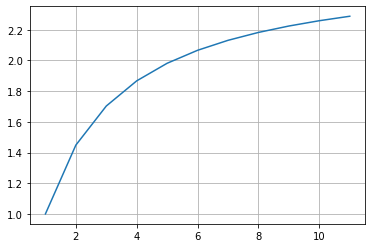

In [41]:
slaves = range(1, 12)
plt.grid()
plt.plot(slaves, list(map(lambda x: speedup(x, S, P), slaves)))

### With Assembly slocs
(Assuming ratio of C-slocs/Asm-slocs is NOT constant throughout the codebase).

#### Decompiling the executable and counting the lines of code used by each part of the program:

In [14]:
! mpic++ -g -O0 -fno-builtin ../src/parallel/main.cpp -o a.out
!  objdump -fsd --source a.out > dump.txt
! rm a.out
asm_code = ! cat dump.txt


##### Approx. Intervals from dump.txt (objump data):

In [15]:
dif = lambda a, b : abs(a-b) # distance between a and b 
master = dif( *[asm_code.index(x) for x in asm_code if "MASTER" in x])
slave = dif( *[asm_code.index(x) for x in asm_code if "SLAVE" in x])
search = dif( *[asm_code.index(x) for x in asm_code if "RABINKARP" in x])
read = dif( *[asm_code.index(x) for x in asm_code if "READFILE" in x])

tot = master+slave+search+read
P = (slave+search)/tot
S = 1 - P

print("The percentage of serial code is:", round(S, 2))
print("The percentage of parallel code is:", round(P, 2))


The percentage of serial code is: 0.49
The percentage of parallel code is: 0.51


#### Applying Amdahl Law's Equation

In [16]:
n_slaves = 3
f"With {n_slaves} slave cores, the expected speed-up is: {speedup(n_slaves, S, P)}"

'With 3 slave cores, the expected speed-up is: 1.5125'

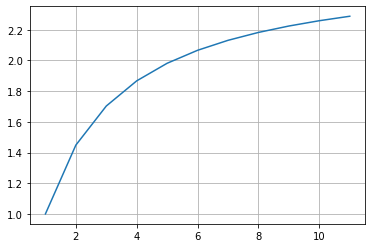

In [39]:
slaves = range(1, 12)
plt.grid()
plt.plot(slaves, list(map(lambda x: speedup(x, S, P), slaves)))